In [34]:
# IMPORTACION DE LIBRERIAS
import numpy as np
import pandas as pd

# LIBRERIAS PARA HACER GRAFICOS
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as xp
from matplotlib import style
from mlxtend.plotting import plot_decision_regions

# PREPROCESADO, MODELADO y VALLIDACIÓN 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


# IGNORAMOS LOS WARNING
import warnings
warnings.filterwarnings('ignore')

# ESTILO DE LOS GRÁFICOS
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['axes.titlesize'] = "10"
style.use('ggplot') or plt.style.use('ggplot')

plt_colors = list(sns.color_palette().as_hex())

def plt_color(i):
    return plt_colors[i % len(plt_colors)]

In [35]:
# CARGA Y LIMPIEZA DE DATOS BÁSICO

! [ -f ASI_casoPractico.csv ] || wget https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/m04/c2/sprint/ASI_casoPractico.csv

# Cargar el dataset
data = pd.read_csv("ASI_casoPractico.csv", sep=";")

# Eliminar columnas innecesarias
data = data.drop(["ID","b","e","DR"], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   int64  
 1   AC        2126 non-null   int64  
 2   FM        2126 non-null   int64  
 3   UC        2126 non-null   int64  
 4   ASTV      2126 non-null   int64  
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   int64  
 7   MLTV      2126 non-null   float64
 8   DL        2126 non-null   int64  
 9   DS        2126 non-null   int64  
 10  DP        2126 non-null   int64  
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

In [36]:
# BORRAR VARIABLES CORRELACIONADAS

# Cluster ["Mode", "Mean", "Median"]
# data.drop(["Mode", "Median"], axis=1, inplace=True) # No mejora

# Cluster ["Max", "Min", "Nmax", "Width"]
data.drop(["Max", "Width", "Nmax"], axis=1, inplace=True)

# Cluster ["ASTV", "MSTV","ALTV"]
# data.drop(["ASTV","MSTV"], axis=1, inplace=True) # No mejora

# VARIABLES DESBALANCEADAS
# data.drop(["DS", "DP"], axis=1, inplace=True) # No mejora

# MAYORÍA DE VALORES CERO
data.drop(["Nzeros"], axis=1, inplace=True) # No Mejora

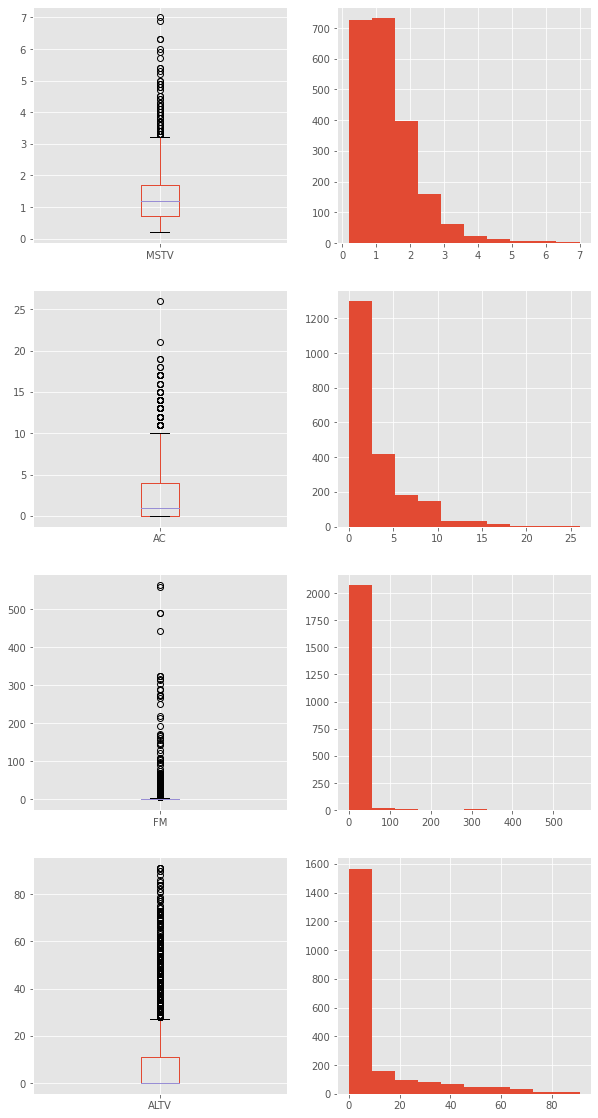

In [37]:
# EXAMINAR OUTLIERS

vars = ["MSTV", "AC", "FM", "ALTV"]
fig = plt.figure(figsize=(10,5*len(vars)))
pid = 0
for v in vars:
  pid += 1
  data.boxplot(column=v, ax = plt.subplot(len(vars),2,pid))
  pid += 1
  data[v].hist(ax = plt.subplot(len(vars),2,pid))

In [38]:
# TRATAMIENTO DE OUTLIERS

def get_limits(variable):
  q1 = variable.quantile(0.25)
  q3 = variable.quantile(0.75)
  iqr = q3 - q1
  return (q1 - 1.5 * iqr), (q3 + 1.5 * iqr)

def get_quartiles(variable):
  quantiles = [0.25, 0.5, 0.75]
  values = []
  for q in quantiles:
    values.append(variable.quantile(q))
  return tuple(values)

## MSTV
name = "MSTV"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por q3
# data[name] = data[name].apply(lambda x: x if x <= top else top)
# sustituir por mediana
med = data[name].median()
data[name] = data[name].apply(lambda x: x if x <= top else med)

## AC
name = "AC"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por q3
# data[name] = data[name].apply(lambda x: x if x <= top else top)
# sustituir por mediana
med = data[name].median()
data[name] = data[name].apply(lambda x: x if x <= top else med)

## FM
name = "FM"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por q3
# data[name] = data[name].apply(lambda x: x if x <= top else top)
# sustituir por mediana
# med = data[name].median()
# data[name] = data[name].apply(lambda x: x if x <= top else med)
# sustituir por 0 o 1
data[name] = data[name].apply(lambda x: 1 if x >= 2 else 0)

## ALTV
name = "ALTV"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por q3
# data[name] = data[name].apply(lambda x: x if x <= top else top)
# sustituir por mediana
# med = data[name].median()
# data[name] = data[name].apply(lambda x: x if x <= top else med)
# sustituir por 0 o 1
data[name] = data[name].apply(lambda x: 1 if x >= 11 else 0)

MSTV 3.2 (0.7, 1.2, 1.7)
AC 10.0 (0.0, 1.0, 4.0)
FM 5.0 (0.0, 0.0, 2.0)
ALTV 27.5 (0.0, 0.0, 11.0)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96afe7ab20>,
      dtype=object)

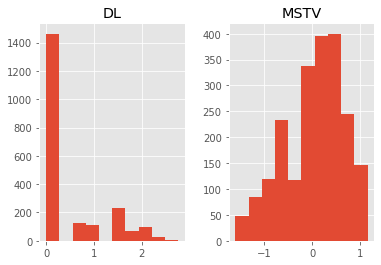

In [39]:
# TRANFORMACIÓN DE VARIABLES

# Transformación logarítmica
# vars = ["ALTV", "FM", "AC", "MSTV"]
# vars = ["MSTV"] 
vars = ["DL", "MSTV"] # Winnner
for v in vars:
  data[v] = data[v].apply(lambda x: np.log(x) if x > 0 else x)

# Convertir variables en dicotómicas
# data["DP"] = data["DP"].apply(lambda x: 0 if x == 0 else 1)
# vars.append("DP")

data[vars].hist()

In [40]:
# sns.pairplot(data, hue="Target")

In [41]:
# # ENCONTRAR UNA BUENA SEMILLA

# X = data.loc[:, data.columns != "Target"]
# y = data.loc[:, data.columns == "Target"]

# # Fuerza bruta
# # Calculamos el AUC para semillas entre [0, 500) y test_size entre [0.3, 0.9)
# from sklearn.metrics import roc_auc_score
# from tqdm.auto import tqdm

# scores = []
# gnb = GaussianNB()

# for seed in tqdm(range(0, 500)):
#   for i in range(4,5):
#     ts = i / 10
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts , random_state = seed)

#     modelNB = gnb.fit(X_train, y_train.values.ravel())
#     y_pred_train = modelNB.predict_proba(X_train) 
#     y_pred_test = modelNB.predict_proba(X_test)

#     auc_train = roc_auc_score(y_train.values.ravel(), y_pred_train[:,1])
#     auc_test = roc_auc_score(y_test.values.ravel(), y_pred_test[:,1])

#     scores.append((ts, seed, auc_train, auc_test))

# # Buscar la mejor combinación de test-size y seed con estos dos objetivos en mente
# # - Minimiza el sobre-ajuste
# # - Maximizar el área bajo la curva con los datos de entrenamiento

# df_scores = pd.DataFrame(data=scores, columns=["test_size", "seed", "auc_train", "auc_test"])

# # Me invento una métrica llamada "performance"
# # - performance = auc_test * (1 - abs(auc_train - auc_test))

# # Esta métrica funciona del siguiente modo
# # - cuanto mayor es auc_test mejor es performance
# # - cuanto mayor es el sobreajuste (auc_train - auc_test) peor es performance

# # Calculamos la métrica
# df_scores["performance"] = df_scores.auc_test * (1 - (np.abs(df_scores.auc_train - df_scores.auc_test)*0.9))

# # Estimamos el sobreajuste para cada test_size y semila

# df_scores["overfit_est"] = np.abs(df_scores.auc_train - df_scores.auc_test)

# # # Obtenemos la mejor combinación
# aux = df_scores.nlargest(3, "performance").reset_index()
# best_ts = aux.loc[0,"test_size"]
# best_seed = aux.loc[0,"seed"]
# print(f"test_size={best_ts}; seed={best_seed}")
# aux

best_ts = 0.4
best_seed = 124

In [42]:
# MUESTREO
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = best_ts, random_state = best_seed)

In [43]:
# ENTRENAMIENTO NAIVE BAYES
gnb = GaussianNB()

modelNB = gnb.fit(X_train, y_train.values.ravel())
y_pred_train_nb = modelNB.predict_proba(X_train) 
y_pred_test_nb = modelNB.predict_proba(X_test)

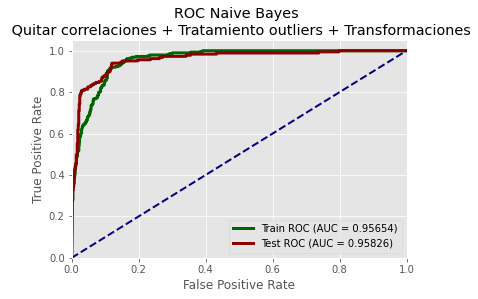

In [44]:
# VALIDACIÓN
#
# Encapsulamos la generación de la curva ROC en una función reutilizable
#
def plot_ROC(y_train, y_test, pred_train, pred_test, title="ROC"):
  # CURVA ROC Y AUC PARA TRAINING
  fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
  roc_auc_train = auc(fpr_train, tpr_train)

  # CURVA ROC Y AUC PARA TEST
  fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
  roc_auc_test = auc(fpr_test, tpr_test)

  # GRAFICA
  plt.figure()
  lw = 2

  plt.plot(fpr_train,tpr_train,color="darkgreen",lw=lw+1,label="Train ROC (AUC = %0.5f)" % roc_auc_train,)
  plt.plot(fpr_test,tpr_test,color="darkred",lw=lw+1,label="Test ROC (AUC = %0.5f)" % roc_auc_test,)

  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

plot_ROC(
    y_train=y_train,
    y_test=y_test,
    pred_train=y_pred_train_nb,
    pred_test=y_pred_test_nb,
    title="ROC Naive Bayes \n Quitar correlaciones + Tratamiento outliers + Transformaciones"
)